# Background Methods

In [1]:
import traceback
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from WF_SDK import device
from WF_SDK import scope
from WF_SDK import wavegen

%matplotlib inline

In [2]:
class ADSHardware():
    """Class of functions for interfacing with the ADS.
    """

    def __init__(self):
        self.handle = None

    def startup(self):
        """Connects to the ADS. Defines 'handle', the address to the ADS.
        Must be run at the beginning of every program using the ADS.
        """
        self.handle = device.open()

    def open_scope(self, buffer_size=1000, sample_freq=100e6):
        """Opens connection to the scope.

        Args:
            buffer_size (int, optional): How many data points are temporarily stored
            before being returned. The buffer is a temporary slot for storing a small amount of
            data before it is transferred to its final destination. Defaults to 1000.
            sample_freq (int, optional): How frequently the oscilloscope will sample
            from the input. Defaults to 100e6. You can decrease this if you have too
            many data points/the function is taking awhile to run for the time scale you need.
            (1e6 or even 16e3 can be reasonable selections.)
        """
        scope.open(self.handle, buffer_size=buffer_size, sampling_frequency=sample_freq)

    def trigger_scope(self, channel=1, level=0.1):
        """Sets trigger level for the scope. Kind of a buggy function; not used.

        Args:
            channel (int, optional): Selects which channel of scope to read out. 
            Defaults to 1.
            level (float, optional): Sets trigger level for scope. Defaults to 0.1.
        """
        scope.trigger(self.handle, enable=True, source=scope.trigger_source.analog, channel=channel,
                      edge_rising=True, level=level)

    def read_scope(self, channel=1):
        """Collects data from the scope.

        Args:
            channel (int, optional): Which channel to read from. Defaults to 1.

        Returns:
            buffer (array): An array of output data points. The buffer is a temporary slot 
            for storing a small amount of data before it is transferred to its final destination.
        """
        buffer = scope.record(self.handle, channel=channel)
        return buffer

    def close_scope(self):
        """Closes connection to the scope.
        """
        scope.close(self.handle)

    def use_wavegen(self, channel=1, function=wavegen.function.sine, offset_v=0, freq_hz=1e3, amp_v=1):
        """Runs the wavegen producing function with given parameters.

        Args:
            channel (int, optional): Which channel output is at. Defaults to 1.
            function (function object, optional): What type of function to output. 
            Defaults to wavegen.function.sine.
            offset (int, optional): Voltage offset (V). Defaults to 0.
            freq (int, optional): Frequency (Hz). Defaults to 1e3.
            amp (int, optional): Amplitude (V). Defaults to 1.
        """
        wavegen.generate(self.handle, channel=channel, function=function, offset=offset_v,
                         frequency=freq_hz, amplitude=amp_v)

    def close_wavegen(self):
        """Closes wavegen.
        """
        wavegen.close(self.handle)

    def disconnect(self):
        """Closes ADS connection. Must be run at the end of every program.
        """
        device.close(self.handle)

In [3]:
def oscilloscope_run(ads_object: ADSHardware, duration: float, channel: int, sampling_freq=400000):
    """Collects data from the oscilloscope.

    Args:
        ads_object (ADSHardware object): the ADS being used
        duration (int): time length of trace to collect in seconds
        channel (int): which channel to collect data from
        sampling_freq (int, optional): How frequently the oscilloscope will sample (Hz)
        from the input. Defaults to 1e6. You can decrease this if you have too
        many data points/the function is taking awhile to run for the time scale you need.
        (16e3 can be a reasonable selection.)

    Returns:
        data (dict): has two keys, "x" and "y" which have time (ms) and voltage (V) data
    """
    buffer_size = int(duration * sampling_freq)
    data = {}
    ads_object.open_scope(sample_freq=sampling_freq, buffer_size=buffer_size)

    MS_CONVERSION = 1e3

    buffer = ads_object.read_scope(channel=channel)
    data["y"] = buffer

    #MODIFY THE LINE BELOW THIS ONE IN L10.2(d)
    data["x"] = np.arange(buffer_size) / sampling_freq * MS_CONVERSION
    
    ads_object.close_scope()
    return data

In [4]:
wavegen_functions = {"sine":wavegen.function.sine, "square":wavegen.function.square,
                     "triangle":wavegen.function.triangle, "dc":wavegen.function.dc, "pulse": wavegen.function.pulse}

# Sonar

In [5]:
ads = ADSHardware()
ads.startup()

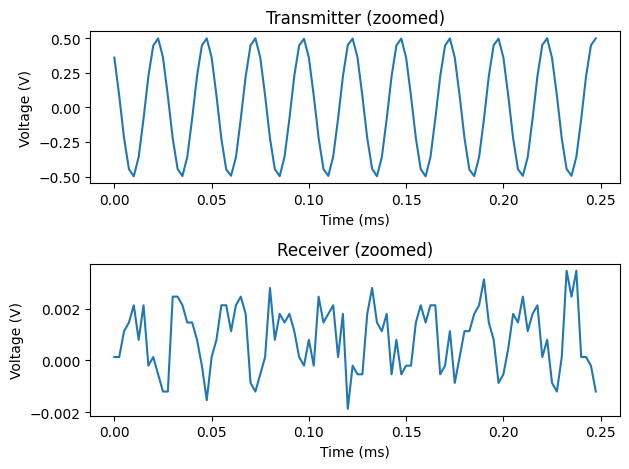

In [9]:
freq  = 40e3
Amp   = 0.5
pulse = 0.02

ads.use_wavegen(channel=1, function=wavegen_functions["sine"], offset_v=0, freq_hz=freq, amp_v=Amp)

sampling_rate = 400000

tx_data = oscilloscope_run(ads, pulse, 1, sampling_freq=sampling_rate)   # transmitter
rx_data = oscilloscope_run(ads, pulse, 2, sampling_freq=sampling_rate)   # receiver

ads.close_wavegen()

t_tx = np.array(tx_data["x"])
v_tx = np.array(tx_data["y"])
t_rx = np.array(rx_data["x"])
v_rx = np.array(rx_data["y"])

# Zoom window (0–0.5 ms)
mask_tx = t_tx < 0.25    # ms
mask_rx = t_rx < 0.25

plt.figure()
plt.subplot(2,1,1)
plt.plot(t_tx[mask_tx], v_tx[mask_tx])
plt.title("Transmitter (zoomed)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")

plt.subplot(2,1,2)
plt.plot(t_rx[mask_rx], v_rx[mask_rx])
plt.title("Receiver (zoomed)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")

plt.tight_layout()
plt.show()

# Sonar Pulse

In [5]:
def oscilloscope_run_two(ads_object: ADSHardware,
                         duration: float,
                         sampling_freq: int = 400_000):
    """
    Collects data from BOTH oscilloscope channels in one go
    (sequential reads with same timing config).

    Returns:
        data (dict): keys "t_ms", "ch1", "ch2"
    """
    buffer_size = int(duration * sampling_freq)

    # Configure scope timing
    ads_object.open_scope(sample_freq=sampling_freq, buffer_size=buffer_size)

    # READ CHANNEL 1
    # Change 'channel=' to whatever your ADSHardware.read_scope expects (e.g. ch=1)
    buf1 = ads_object.read_scope(channel=1)
    # READ CHANNEL 2
    buf2 = ads_object.read_scope(channel=2)

    ads_object.close_scope()

    # Time axis in ms
    t_ms = np.arange(buffer_size) / sampling_freq * 1e3

    # Make sure these are 1-D arrays of length buffer_size
    ch1 = np.array(buf1).flatten()
    ch2 = np.array(buf2).flatten()

    print("ch1 shape:", ch1.shape, "ch2 shape:", ch2.shape)  # debug

    return {"t_ms": t_ms, "ch1": ch1, "ch2": ch2}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

from WF_SDK import device, wavegen, scope

# -----------------------------
# Constants / parameters
# -----------------------------
SOUND_SPEED   = 343.0      # m/s
F_ULTRA       = 40e3       # 40 kHz carrier
BURST_CYCLES  = 40         # cycles per burst
BURST_T       = BURST_CYCLES / F_ULTRA    # ~1 ms burst
WAIT_BEFORE   = 2e-3       # 2 ms wait so scope can arm
CAPTURE_T     = 0.02       # 20 ms capture window
FS_SCOPE      = 1_000_000  # 1 MS/s scope sample rate
AWG_VPP       = 4.0        # 4 Vpp at Wavegen output (±2 V)

# -----------------------------
# Open device
# -----------------------------
dev = device.open()
print("Device opened.")

# -----------------------------
# Configure scope
# -----------------------------
N_SAMPLES = int(FS_SCOPE * CAPTURE_T)

# Adjust keyword names if your WF_SDK is slightly different
scope.open(
    dev,
    sampling_frequency=FS_SCOPE,
    buffer_size=N_SAMPLES,
)

# Trigger on CH1 rising edge near start of burst
scope.trigger(
    dev,
    enable=True,
    source="channel1",  # or whatever your SDK expects
    level=0.2,          # trigger level (V)
    edge="rising",
    position=0.1        # 10% pre-trigger in the record
)

# -----------------------------
# Configure Wavegen burst
# -----------------------------
# Use a plain sine; burst behavior is controlled by run_time + repeat
wavegen.generate(
    dev,
    channel=1,
    function=wavegen.function.sine,
    offset=0.0,
    frequency=F_ULTRA,
    amplitude=AWG_VPP / 2,  # amplitude is peak, not p-p
    symmetry=50,
    wait=WAIT_BEFORE,       # wait before starting burst
    run_time=BURST_T,       # duration of output
    repeat=1,               # play this burst once
)

# -----------------------------
# Acquire data (both channels)
# -----------------------------
# Depending on your WF_SDK version, scope.record may return:
#   t_array, ch1_array, ch2_array
# or a dict. Adjust accordingly.
t, ch1, ch2 = scope.record(dev, enable=[True, True])

t = np.asarray(t)          # seconds
tx_raw = np.asarray(ch1)   # Tx probe
rx_raw = np.asarray(ch2)   # Rx receiver

print("Recorded:", tx_raw.shape[0], "samples.")

# -----------------------------
# Bandpass filter around 40 kHz
# -----------------------------
low = 30e3
high = 50e3
b, a = sig.butter(4, [low, high], btype="bandpass", fs=FS_SCOPE)

tx = sig.lfilter(b, a, tx_raw)
rx = sig.lfilter(b, a, rx_raw)

# -----------------------------
# Find Tx burst start time
# -----------------------------
# Simple threshold on the filtered Tx
tx_abs = np.abs(tx)
thr_tx = 0.3 * np.max(tx_abs)   # 30% of peak
idx_tx_start = np.argmax(tx_abs > thr_tx)
t_tx_start = t[idx_tx_start]

# -----------------------------
# Cross-correlate to find echo delay
# -----------------------------
corr = sig.correlate(rx, tx, mode="full")
lags = sig.correlation_lags(len(rx), len(tx), mode="full")
lag_sec = lags / FS_SCOPE
corr_abs = np.abs(corr)

# Largest peak overall is direct coupling; should be near 0 lag
idx_direct = np.argmax(corr_abs)
t_direct = lag_sec[idx_direct]

# Look for echo peak at positive lags beyond some minimum
# Minimum lag ~ 2 * (10 cm) / 343 m/s ~ 0.6 ms; be conservative and use 1 ms
min_echo_time = 1e-3
echo_mask = lag_sec > min_echo_time

if np.any(echo_mask):
    idx_echo_rel = np.argmax(corr_abs[echo_mask])
    idx_echo = np.where(echo_mask)[0][idx_echo_rel]
    dt_echo = lag_sec[idx_echo]          # seconds (Rx vs Tx)
    distance = 0.5 * SOUND_SPEED * dt_echo
else:
    dt_echo = np.nan
    distance = np.nan

t_echo_absolute = t_tx_start + dt_echo if np.isfinite(dt_echo) else np.nan

print(f"Tx burst start time   ≈ {t_tx_start*1e3:.3f} ms (within record)")
print(f"Direct peak lag       ≈ {t_direct*1e3:.3f} ms")
print(f"Echo lag (Tx→Rx)      ≈ {dt_echo*1e3:.3f} ms")
print(f"Echo absolute time    ≈ {t_echo_absolute*1e3:.3f} ms")
print(f"Estimated distance    ≈ {distance:.3f} m")

# -----------------------------
# Plots for sanity
# -----------------------------
# Zoom on first few ms to see Tx burst + echo structure
mask_zoom = (t >= 0) & (t <= 0.01)  # 0–10 ms

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t[mask_zoom]*1e3, tx[mask_zoom])
plt.axvline(t_tx_start*1e3, color="k", linestyle="--", label="Tx start")
plt.xlabel("Time (ms)")
plt.ylabel("Tx (V, filtered)")
plt.legend()
plt.title("Tx burst around 40 kHz")

plt.subplot(2, 1, 2)
plt.plot(t[mask_zoom]*1e3, rx[mask_zoom])
plt.axvline((t_tx_start + dt_echo)*1e3, color="r", linestyle="--", label="Echo")
plt.xlabel("Time (ms)")
plt.ylabel("Rx (V, filtered)")
plt.legend()
plt.title("Rx signal with echo mark (if found)")

plt.tight_layout()
plt.show()

# Correlation plot
plt.figure()
plt.plot(lag_sec*1e3, corr_abs)
plt.axvline(0, color="k", linestyle="--", label="direct (0)")
if np.isfinite(dt_echo):
    plt.axvline(dt_echo*1e3, color="r", linestyle="--", label="echo")
plt.xlim(-2, 12)  # ms
plt.xlabel("Lag (ms)")
plt.ylabel("|corr|")
plt.legend()
plt.title("Cross-correlation |Rx ⊗ Tx|")
plt.show()

# -----------------------------
# Cleanup
# -----------------------------
wavegen.close(dev)   # stop / reset wavegen
scope.close(dev)
device.close(dev)
print("Device closed.")


Device opened.


TypeError: trigger() got an unexpected keyword argument 'edge'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

from WF_SDK import device, wavegen, scope

# -----------------------------
# Constants / parameters
# -----------------------------
SOUND_SPEED   = 343.0      # m/s
F_ULTRA       = 40e3       # 40 kHz carrier
BURST_CYCLES  = 40         # cycles per burst
BURST_T       = BURST_CYCLES / F_ULTRA    # ~1 ms burst
WAIT_BEFORE   = 2e-3       # 2 ms wait before burst starts
CAPTURE_T     = 0.02       # 20 ms capture window
FS_SCOPE      = 1_000_000  # 1 MS/s scope sample rate
AWG_VPP       = 4.0        # 4 Vpp at Wavegen output (±2 V)

# -----------------------------
# Open device and scope
# -----------------------------
dev = device.open()
print("Device opened.")

N_SAMPLES = int(FS_SCOPE * CAPTURE_T)

# According to your docs: open(device_data, sampling_frequency, buffer_size, offset, amplitude_range)
scope.open(
    dev,
    sampling_frequency=FS_SCOPE,
    buffer_size=N_SAMPLES,
    offset=0,
    amplitude_range=5
)

# -----------------------------
# Configure Wavegen burst on CH1
# -----------------------------
# Use a sine; burst behavior via wait + run_time + repeat
wavegen.generate(
    dev,
    channel=1,
    function=wavegen.function.sine,
    offset=0.0,
    frequency=F_ULTRA,
    amplitude=AWG_VPP / 2,  # amplitude is peak, not p-p
    symmetry=50,
    wait=WAIT_BEFORE,       # wait before starting burst
    run_time=BURST_T,       # duration of output
    repeat=1,               # one burst
    data=[]
)

# -----------------------------
# Record Rx channel (CH2)
# -----------------------------
# Your docs: record(device_data, channel) -> buffer, time (seconds)
rx_buffer, t = scope.record(dev, channel=2)

t = np.asarray(t)          # seconds, length N_SAMPLES
rx_raw = np.asarray(rx_buffer)

print("Recorded:", rx_raw.shape[0], "samples.")

# -----------------------------
# Build known Tx template in software
# -----------------------------
# We know exactly what we transmitted: 40 kHz sine for BURST_T seconds.
N_pulse = int(BURST_T * FS_SCOPE)
dt = 1.0 / FS_SCOPE
t_pulse = np.arange(N_pulse) * dt

tx_template = np.sin(2 * np.pi * F_ULTRA * t_pulse)

# Apply a window to taper the edges (reduces sidelobes in correlation)
window = np.hanning(N_pulse)
tx_template *= window

# -----------------------------
# Bandpass filter Rx around 40 kHz
# -----------------------------
low = 30e3
high = 50e3
b, a = sig.butter(4, [low, high], btype="bandpass", fs=FS_SCOPE)
rx_f = sig.lfilter(b, a, rx_raw)

# -----------------------------
# Cross-correlate Rx with Tx template
# -----------------------------
corr = sig.correlate(rx_f, tx_template, mode="full")
lags = sig.correlation_lags(len(rx_f), len(tx_template), mode="full")
lag_sec = lags / FS_SCOPE
corr_abs = np.abs(corr)

# Ignore negative lags; we only care about responses *after* transmit
pos_mask = lag_sec >= 0
lags_pos = lags[pos_mask]
lag_sec_pos = lag_sec[pos_mask]
corr_pos = corr_abs[pos_mask]

# Find the strongest peak at positive lag
idx_peak = np.argmax(corr_pos)
lag_samples_tof = lags_pos[idx_peak]
dt_tof = lag_samples_tof / FS_SCOPE    # seconds

distance = 0.5 * SOUND_SPEED * dt_tof

print(f"Time-of-flight (Tx→echo) ≈ {dt_tof*1e3:.3f} ms")
print(f"Estimated distance        ≈ {distance:.3f} m")

# -----------------------------
# "Timestamps" within the record
# -----------------------------
# In the scope timebase, we can say the echo appears at:
t_echo_record = t[0] + dt_tof   # since t[0] is record start; usually 0

print(f"Echo arrival time in record ≈ {t_echo_record*1e3:.3f} ms after record start")

# -----------------------------
# Plots for sanity
# -----------------------------
# 1) Rx waveform (first 10 ms)
mask_zoom = (t >= 0) & (t <= 0.01)  # 0–10 ms

plt.figure()
plt.plot(t[mask_zoom]*1e3, rx_f[mask_zoom])
plt.axvline(dt_tof*1e3, color="r", linestyle="--", label="Echo TOF")
plt.xlabel("Time (ms)")
plt.ylabel("Rx filtered (V)")
plt.title("Rx signal (filtered) with estimated echo time")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Correlation plot
plt.figure()
plt.plot(lag_sec_pos*1e3, corr_pos)
plt.axvline(dt_tof*1e3, color="r", linestyle="--", label="TOF peak")
plt.xlabel("Lag (ms)")
plt.ylabel("|corr|")
plt.title("Cross-correlation |Rx ⊗ Tx_template| (positive lags)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# Cleanup
# -----------------------------
wavegen.close(dev, channel=1)
device.close(dev)
print("Device closed.")


Device opened.


ValueError: too many values to unpack (expected 2)